## Helper function that all cells need

In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyomo.opt import SolverFactory
from sklearn.manifold import TSNE
from itertools import combinations
import seaborn as sns
import pandas as pd
from IPython.display import display
from src.analyses.convergence_analysis import HausdorffAnalyzer

def is_subset(list_a, list_b):
    # check if list_a is a subset of list_b
    return list_b[0] <= list_a[0] and list_a[1] <= list_b[1]
def return_counter(lamda,node_list,sol,y_bound,volume=True):
    counter=0
    flag=0
    if volume:
        lamda=lamda**(1/len(sol))
    for node in node_list.get_all_bounds():
        for i in sol:
            intv=[sol[i]-lamda*(sol[i]-y_bound[i][0]),sol[i]+lamda*(y_bound[i][1]-sol[i])]
            if not is_subset(node[i],intv):
                flag=1
                break
        if not flag:
            counter+=1
        else:
            flag=0
    return counter
def generate_tree(root):
    if root.left is None and root.right is None:
        return {"name":str(root.idx),"lbd":"{:.4e}".format(root.lbd)}
    elif int(root.idx)>1000:
        return {"name":str(root.idx),"lbd":"{:.2e}".format(root.lbd)}
    else:
        return {"name":str(root.idx),"lbd":"{:.2e}".format(root.lbd),"children":[generate_tree(root.left),generate_tree(root.right)]}
def pairwise_visualize(data,start_from=0,idx_list=None,ignore_columns=None):
    x = np.array([get_midpt(i) for i in data.node_list.get_all_bounds()[start_from:]])
    # Compute 2-norm (Euclidean norm) for each row
    norms = np.linalg.norm(np.array([get_width(i) for i in data.node_list.get_all_bounds()[start_from:]]), axis=1)

    # Create DataFrame
    features=list(data.node_list.get_all_bounds()[0].keys())
    df = pd.DataFrame(x, columns=features)
    df['Norm'] = norms  # Add norms as a new column
    df["index_column"]=df.index
    # Create pairplot
    if idx_list is None:
        if ignore_columns is not None:
            features=[idx for idx in features if idx not in ignore_columns]
        g = sns.pairplot(df,
                        vars=features,
                        hue='Norm',            # Use Norm for color
                        palette='viridis',     # Continuous color map
                        plot_kws={'s': 30, 'alpha': 0.7})
    
    else:
        plt.scatter(df[idx_list[0]], df[idx_list[1]], c=df['Norm'], cmap='viridis', s=50, alpha=0.8)
        plt.colorbar(label='Node Width Aboslute')  # show colorbar to interpret colors
        plt.xlabel(idx_list[0])
        plt.ylabel(idx_list[1])
        plt.title('Scatter plot')

    plt.show()

def get_midpt(bounds):
    midpoints = np.array([(v[0] + v[1]) / 2 for v in bounds.values()])
    return midpoints

def get_width(bounds):
    widths = np.array([v[1] - v[0] for v in bounds.values()])
    return widths

def return_cost_per_node(data):
    solver=SolverFactory('baron')
    results=solver.solve(data.model.origin_model)

    cost_of_root_node_direct=results.solver.root_node_time
    root_time_master=[]
    time_master=[]
    count_master=[]
    for node in data.node_list.nodes.values():
        time_master+=node.lbd_time_cz
        count_master+=node.inner_nodes_count
        root_time_master+=node.root_node_time

    sum_time_rootless=0
    sum_count_rootless=0
    sum_time_rootful=0
    sum_count_rootful=0
    for idx,i in enumerate(count_master):
        if i is not None: #if subproblem is solved otherwise inherit soluton from parent
            if abs(i)!=1: # if subproblem is feasible
                sum_count_rootless+=i-1
                sum_time_rootless+=time_master[idx]-root_time_master[idx]
                sum_count_rootful+=i
                sum_time_rootful+=time_master[idx]
            else: # if subproblem is infeasible or solved in root node during preprocessing
                sum_count_rootful+=abs(i)
                sum_time_rootful+=time_master[idx]


    num_nodes_total=[int(results["Problem"][0]["Iterations"]),sum_count_rootful]
    time_total=[results["Problem"][0]["Wall time"],sum_time_rootful]
    num_nodes_rootless=[int(results["Problem"][0]["Iterations"])-1,sum_count_rootless]
    time_rootless=[results["Problem"][0]["Wall time"]-cost_of_root_node_direct,sum_time_rootless]
    df=pd.DataFrame({
        "num_nodes_total":num_nodes_total,
        "time_total":time_total,
        "num_nodes_rootless":num_nodes_rootless,
        "time_rootless":time_rootless,

    },index=["direct","cz"])
    df["per_node_total"]=df["time_total"]/df["num_nodes_total"]
    df["per_node_rootless"]=df["time_rootless"]/df["num_nodes_rootless"]
    display(df)
    # return {"time_master":time_master,
    #         "count_master":count_master,
    #         "root_time_master":root_time_master}

def pca_nodes(data,start_from=0,instance_name=""):
    highlight_idx = data.node_list.find_min_lbd()[0]
    x = np.array([get_midpt(i) for i in data.node_list.get_all_bounds()[start_from:]])

    # Normalize the data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    # Perform PCA analysis
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x)

    # Plot the PCA result
    indices=np.linalg.norm(np.array([get_width(i) for i in data.node_list.get_all_bounds()[start_from:]]), axis=1)
    scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=indices, cmap='plasma',label="node")
    plt.colorbar(scatter, label='Node Width Absolute')

    # Highlight the specific node
    if highlight_idx >= start_from:
        highlight_idx -= start_from
        plt.scatter(x_pca[highlight_idx, 0], x_pca[highlight_idx, 1],
                color='red', marker='*', s=200)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'{instance_name} - PCA of Nodes')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"PCA components: {pca.components_}")
def t_sne_nodes(data,start_from=0,instance_name=""):
    highlight_idx = data.node_list.find_min_lbd()[0]
    x = np.array([combine_list(i) for i in data.node_list.get_all_bounds()[start_from:]])

    # Normalize the data
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    x_tsne = tsne.fit_transform(x)
    lamda_function = lambda x: sum([element**2 for idx, element in enumerate(x) if idx % 2 == 1])**0.5
    indices = [lamda_function(i) for i in x]
    # Plot the t-SNE result
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], alpha=0.7, c=indices,cmap='viridis')
    if highlight_idx >= start_from:
        highlight_idx -= start_from
        plt.scatter(x_tsne[highlight_idx, 0], x_tsne[highlight_idx, 1],
                color='red', marker='*', s=200)
    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(label='Node Width Normalized')
    plt.grid(True)
    plt.show()
def lbds_ubds(data,start_from=0):
    lbds=[]
    ubds=[]
    for node_bound in list(data.node_list.nodes.values())[start_from:]:
        lbds.append(node_bound.lbd)
        ubds.append(node_bound.ubd)
    plt.plot(lbds,label="lbds")
    plt.plot(ubds,label="ubds")
    plt.legend()
    plt.xlabel('Node Index')
    plt.ylabel('Obj')
    plt.title('Objective Value of Each Node')
    plt.show()
def return_invalid_nodes(data):
    invalid_nodes={}
    for node in data.node_list.nodes.values():
        if node.left:
            if node.lbd>node.left.lbd:
                invalid_nodes[node.idx]=(node.left.lbd-node.lbd)/node.lbd
        elif node.right:
            if node.lbd>node.right.lbd:
                invalid_nodes[node.idx]=(node.left.lbd-node.lbd)/node.lbd
    return invalid_nodes
def total(node):
    if node.left is None and node.right is None:
        return 0
    else: 
        return total(node.left)+total(node.right)+1
def height_balance_ratio(root):
    if root is None:
        return 1  # A null tree is perfectly balanced
    
    left_height = tree_balance_factor(root.left)
    right_height = tree_balance_factor(root.right)
    
    if max(left_height, right_height) == 0:
        return 1  # Avoid division by zero for single-node trees
    
    return min(left_height, right_height) / max(left_height, right_height)
def tree_balance_factor(node):
    if node is None:
        return 0
    
    left_height = tree_balance_factor(node.left)
    right_height = tree_balance_factor(node.right)
    
    return max(left_height, right_height) + 1
def print_lbd_time(data):
    for node in data.node_list.nodes.values():
        print(node.lbd_time_cz)
plt.style.use(['./src/utility/' + i + '.mplstyle' for i in ['font-sans', 'size-4-4', 'fontsize']])

## FLECCS visualize BB

In [ ]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/FLECCS.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

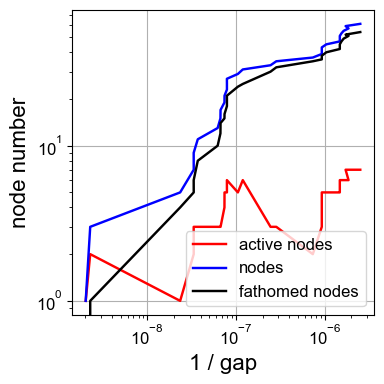

In [ ]:
data.res.plot_bb_n_gap(plot_method='loglog')

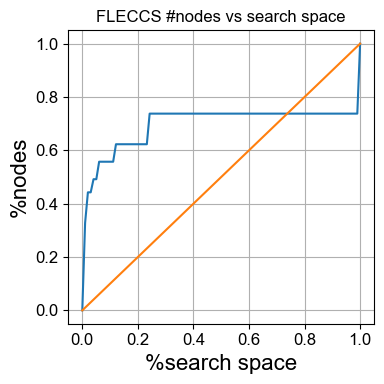

In [ ]:
fleccs_obj = -4.946928843629e+08  # Replace with actual value
fleccs_sol = {'x_sorbent_total': 0.7571021770410511,
  'x_air_adsorb_max': 0.7567643358197031} 
fleccs_y_bound = {'x_sorbent_total': [0.0, 1.0],"x_air_adsorb_max": [0.0, 1.0]}
lambda_list = np.linspace(0, 1, 100)

plt.plot(lambda_list, [return_counter(i, data.node_list, fleccs_sol, fleccs_y_bound)/data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list, label='y=x')
plt.grid()
plt.xlabel('%search space')
plt.ylabel('%nodes')
plt.title('FLECCS #nodes vs search space')
plt.show()

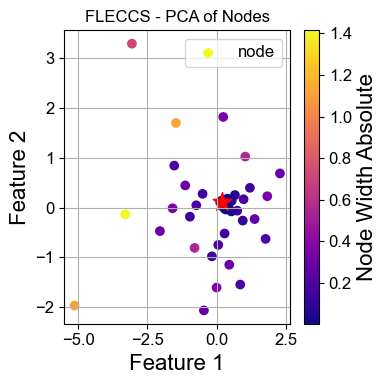

Explained variance ratio: [0.69120343 0.30879657]
PCA components: [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


In [ ]:
pca_nodes(data,instance_name="FLECCS")


## poutil visualize BB (LP)

In [ ]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/poutil.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

BB node list (21/99)

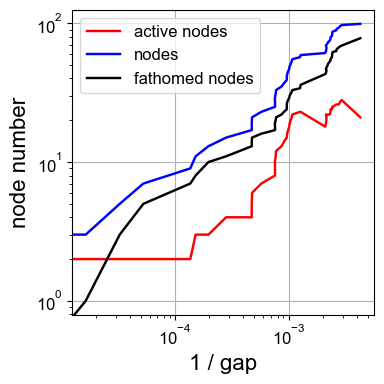

In [ ]:
data.res.plot_bb_n_gap(plot_method='loglog')

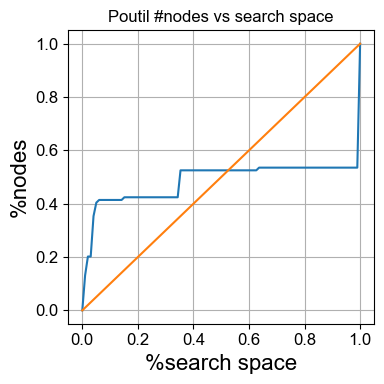

In [ ]:
poutil_obj = 266187.5332404778  # Replace with actual value
poutil_sol = {'alpha': 74.94473247856709, 'beta': 9.000000000000028}  # Replace with actual solution values
poutil_y_bound = {'alpha': [0.0, 470], 'beta': [0.0, 470]}  # Replace with actual bounds
lambda_list = np.linspace(0, 1, 100)
plt.plot(lambda_list, [return_counter(i, data.node_list, poutil_sol, poutil_y_bound) / data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list)
plt.grid()
plt.xlabel('%search space')
plt.ylabel('%nodes')
plt.title('Poutil #nodes vs search space')
plt.show()

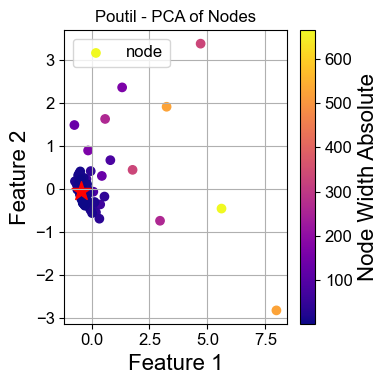

Explained variance ratio: [0.79096671 0.20903329]
PCA components: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


In [ ]:
pca_nodes(data,instance_name="Poutil")

## ex844 visualize BB (NLP) k=0.8142217048578059

In [3]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/data/ex8_4_4.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

BB node list (7998/33799)

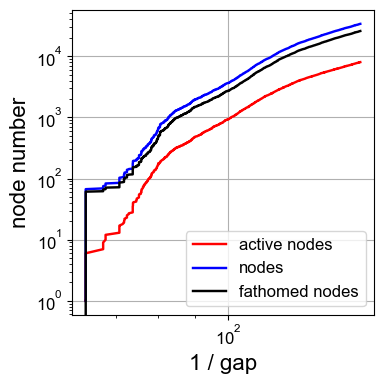

In [4]:
data.res.plot_bb_n_gap(plot_method='loglog')

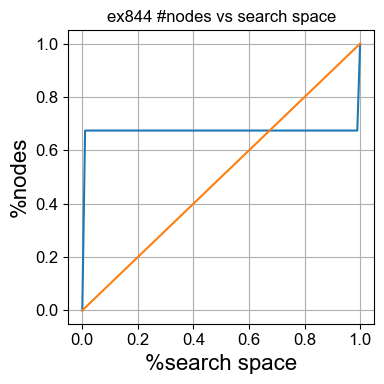

In [ ]:
ex844_obj = 0.3271727784124705  # Replace with actual value
ex844_sol = {
    'x10': -0.2312967690336901, 'x11': 1.2253372994313552, 'x12': 0.052630832446715556,
    'x13': 0.5618257692680865, 'x14': 0.6216502181350324, 'x15': 1.1000095777262031,
    'x16': 0.8068436769745404, 'x17': 0.6631451887968607, 'x6': -1.1369964050673889,
    'x7': 1.5982806594034324, 'x8': -0.5986830473820272, 'x9': 1.3726907085349922
}
ex844_y_bound = {
    'x10': [-1.2, 0.8], 'x11': [0.1, 2.1], 'x12': [-1.1, 0.9], 'x13': [0, 1],
    'x14': [0, 1], 'x15': [1.1, 1.3], 'x16': [0, 1], 'x17': [0, 1],
    'x6': [-2, 0], 'x7': [0.5, 2.5], 'x8': [-1.5, 0.5], 'x9': [0.2, 2.2]
}
lambda_list = np.linspace(0, 1, 100)
plt.plot(lambda_list, [return_counter(i, data.node_list, ex844_sol, ex844_y_bound) / data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list, label='y=x')
plt.grid()
plt.xlabel('%search space')
plt.ylabel('%nodes')
plt.title('ex844 #nodes vs search space')
plt.show()

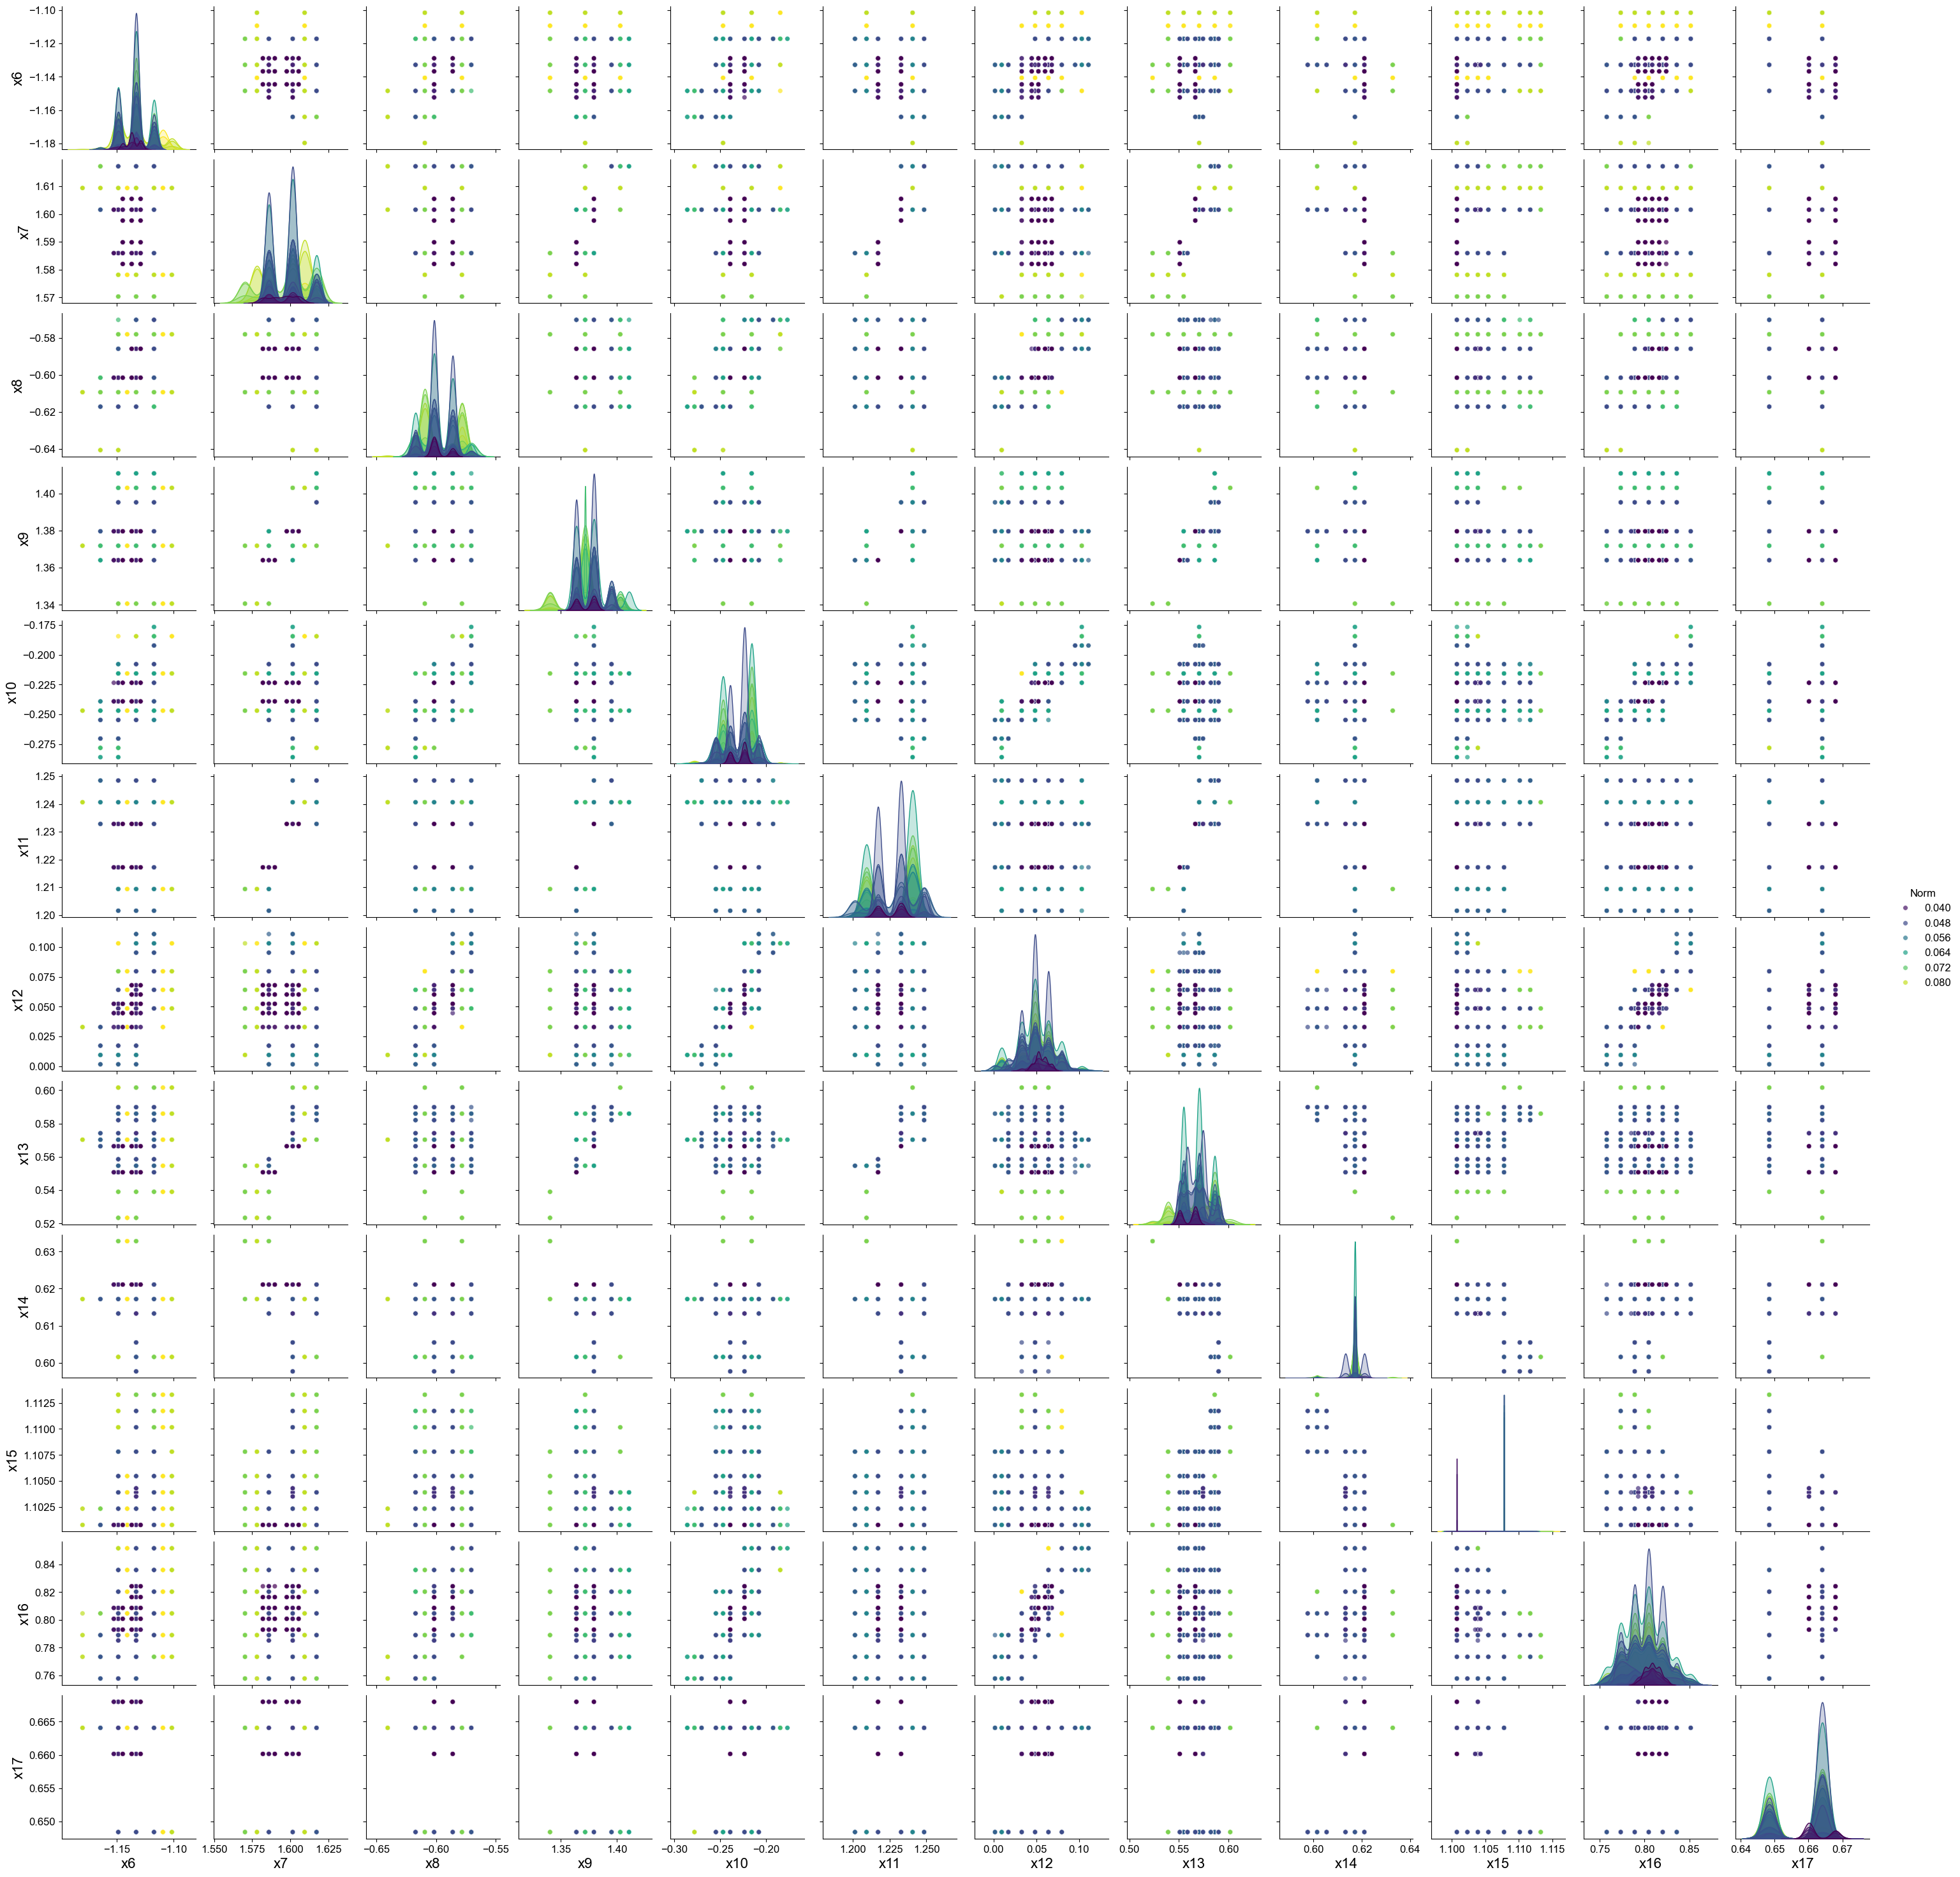

In [ ]:
pairwise_visualize(data,start_from=20000)

In [9]:
return_cost_per_node(data)

num_nodes_total    time_total  num_nodes_rootless  time_rootless  \
direct               23      0.350000                  22       0.240000   
cz               129237  18836.575039               41546    1917.520535   

        per_node_total  per_node_rootless  
direct        0.015217           0.010909  
cz            0.145752           0.046154

## process visualize BB (NLP) k=2.3557730677447988

In [2]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/data/process.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

BB node list (8856/35115)

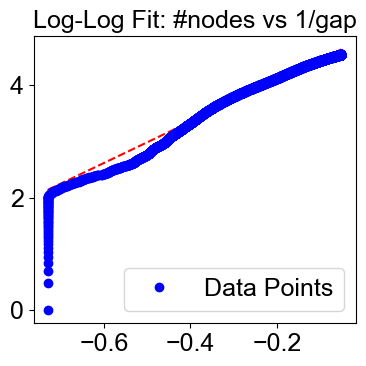

Slope: 3.6833, Intercept: 4.8264, R^2: 0.9757


In [4]:
from scipy.stats import linregress

gap_rec = [1 / g for g in data.res.abs_gaps]
start=0

x = np.log10(gap_rec[start:])
y = np.log10(data.res.bb_n[start:])
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, (intercept + slope * x), 'r--')
plt.plot(x, y, 'bo', label='Data Points')
plt.legend()
plt.title('Log-Log Fit: #nodes vs 1/gap')
plt.show()
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R^2: {r_value**2:.4f}")

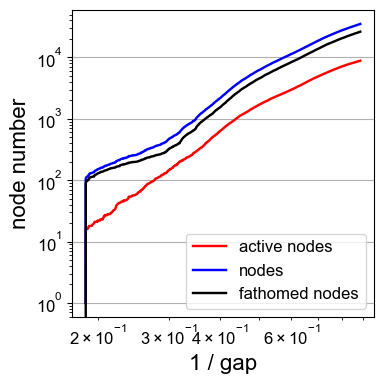

In [4]:
data.res.plot_bb_n_gap(plot_method='loglog')

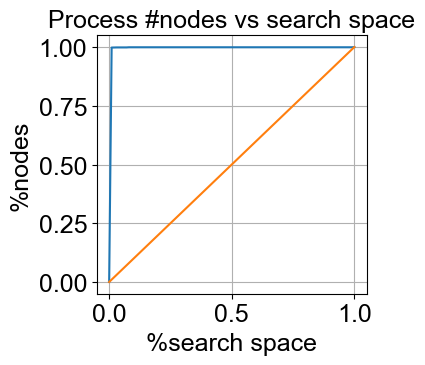

In [3]:
process_obj = -1126.4218270121305
process_sol = {"x1":1727,"x2":16000,"x3":104.23841084280052,"x5":2000}
process_y_bound = {"x1":[10,2000],"x2":[0,16000],"x3":[0,120],"x5":[0,2000]}
lambda_list=np.linspace(0,1,100)

plt.plot(lambda_list, [return_counter(i, data.node_list, process_sol, process_y_bound)/data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list)
plt.grid()
plt.xlabel('%search space')
plt.ylabel('%nodes')
plt.title('Process #nodes vs search space')
plt.show()

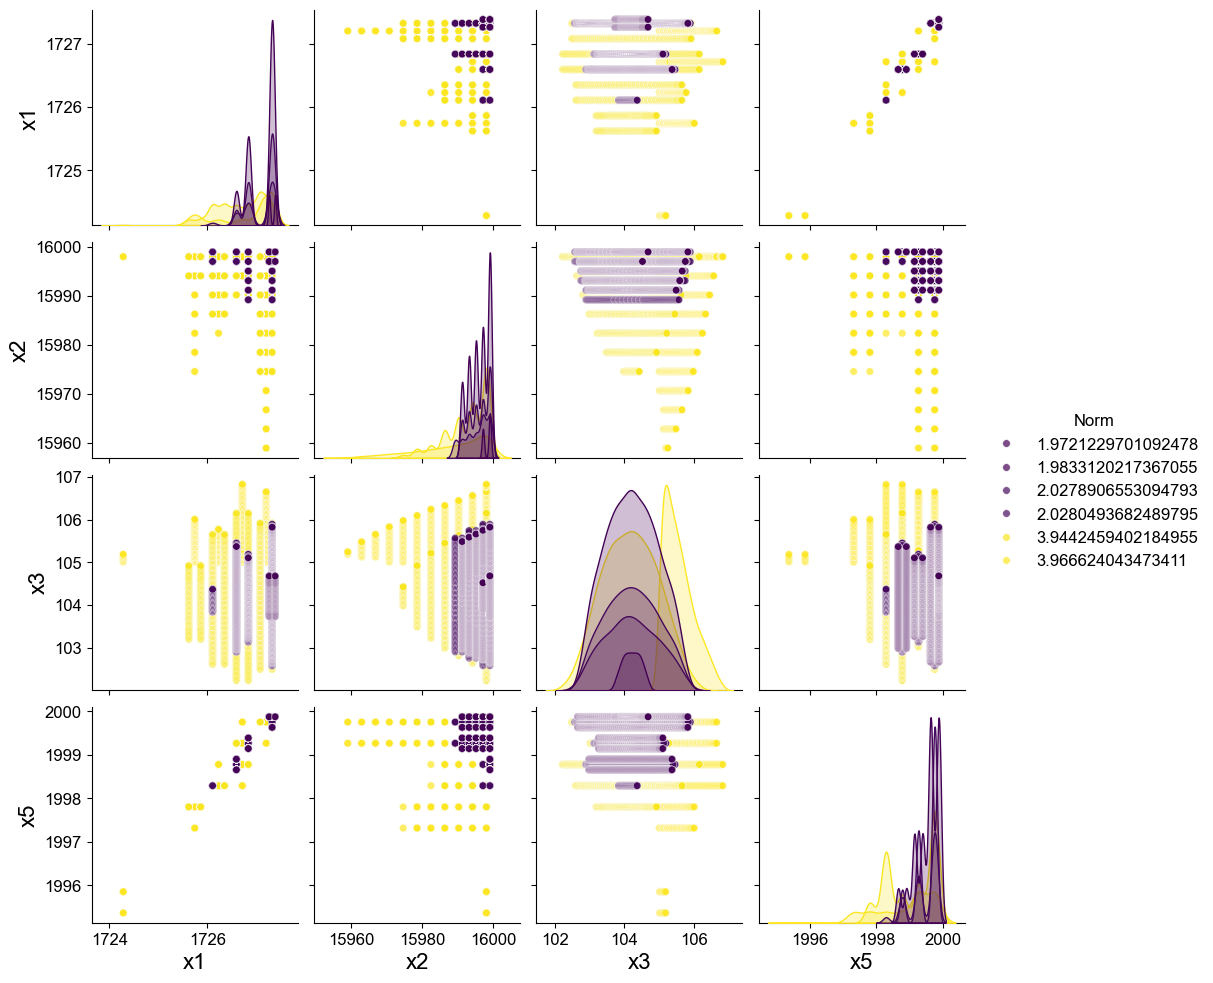

In [ ]:
pairwise_visualize(data,start_from=25000,idx_list=None)

In [3]:
return_cost_per_node(data)

num_nodes_total    time_total  num_nodes_rootless  time_rootless  \
direct             1385      3.040000                1384       2.850000   
cz                98550  16614.725221                1658      28.896902   

        per_node_total  per_node_rootless  
direct        0.002195           0.002059  
cz            0.168592           0.017429

## pooling visualization BB (MINLP) k=1.6045887032133328

In [3]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/data/pooling.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

BB node list (9276/22293)

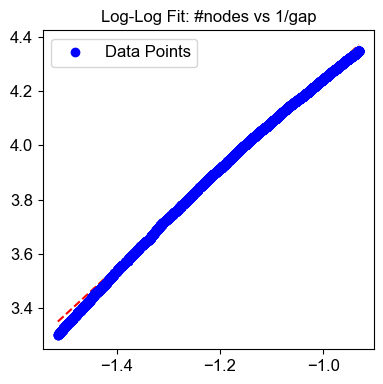

Slope: 1.7538, Intercept: 6.0043, R^2: 0.9971


In [7]:
from scipy.stats import linregress

gap_rec = [1 / g for g in data.res.abs_gaps]
start=1000

x = np.log10(gap_rec[start:])
y = np.log10(data.res.bb_n[start:])
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, (intercept + slope * x), 'r--')
plt.plot(x, y, 'bo', label='Data Points')
plt.legend()
plt.title('Log-Log Fit: #nodes vs 1/gap')
plt.show()
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R^2: {r_value**2:.4f}")

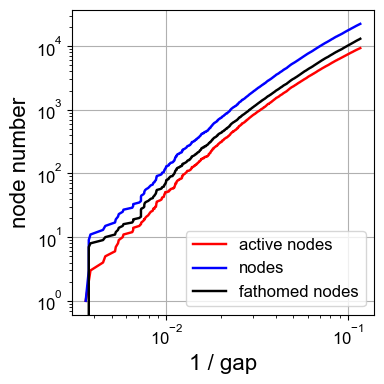

In [4]:
data.res.plot_bb_n_gap(plot_method='loglog')

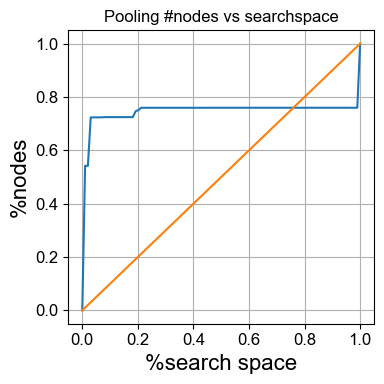

In [ ]:
pooling_obj = -1338.2471283376394
pooling_sol = {
    'A[1]': 300.0, 'A[2]': 201.92127476313524, 'A[3]': 0.0, 'A[4]': 0.0, 'A[5]': 245.18105081826008,
    'S[1]': 247.10232558139526, 'S[2]': 0.0, 'S[3]': 0.0, 'S[4]': 500.0
}
pooling_y_bound = {
    'A[1]': [0, 300], 'A[2]': [0, 250], 'A[3]': [0, 0], 'A[4]': [0, 0], 'A[5]': [0, 300],
    'S[1]': [0, 400], 'S[2]': [0, 0], 'S[3]': [0, 0], 'S[4]': [0, 500]
}
lambda_list = np.linspace(0, 1, 100)

plt.plot(lambda_list, [return_counter(i, data.node_list, pooling_sol, pooling_y_bound)/data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list, label='y=x')
plt.grid()
plt.xlabel('%search space')
plt.ylabel('%nodes')
plt.title('Pooling #nodes vs searchspace')
plt.show()

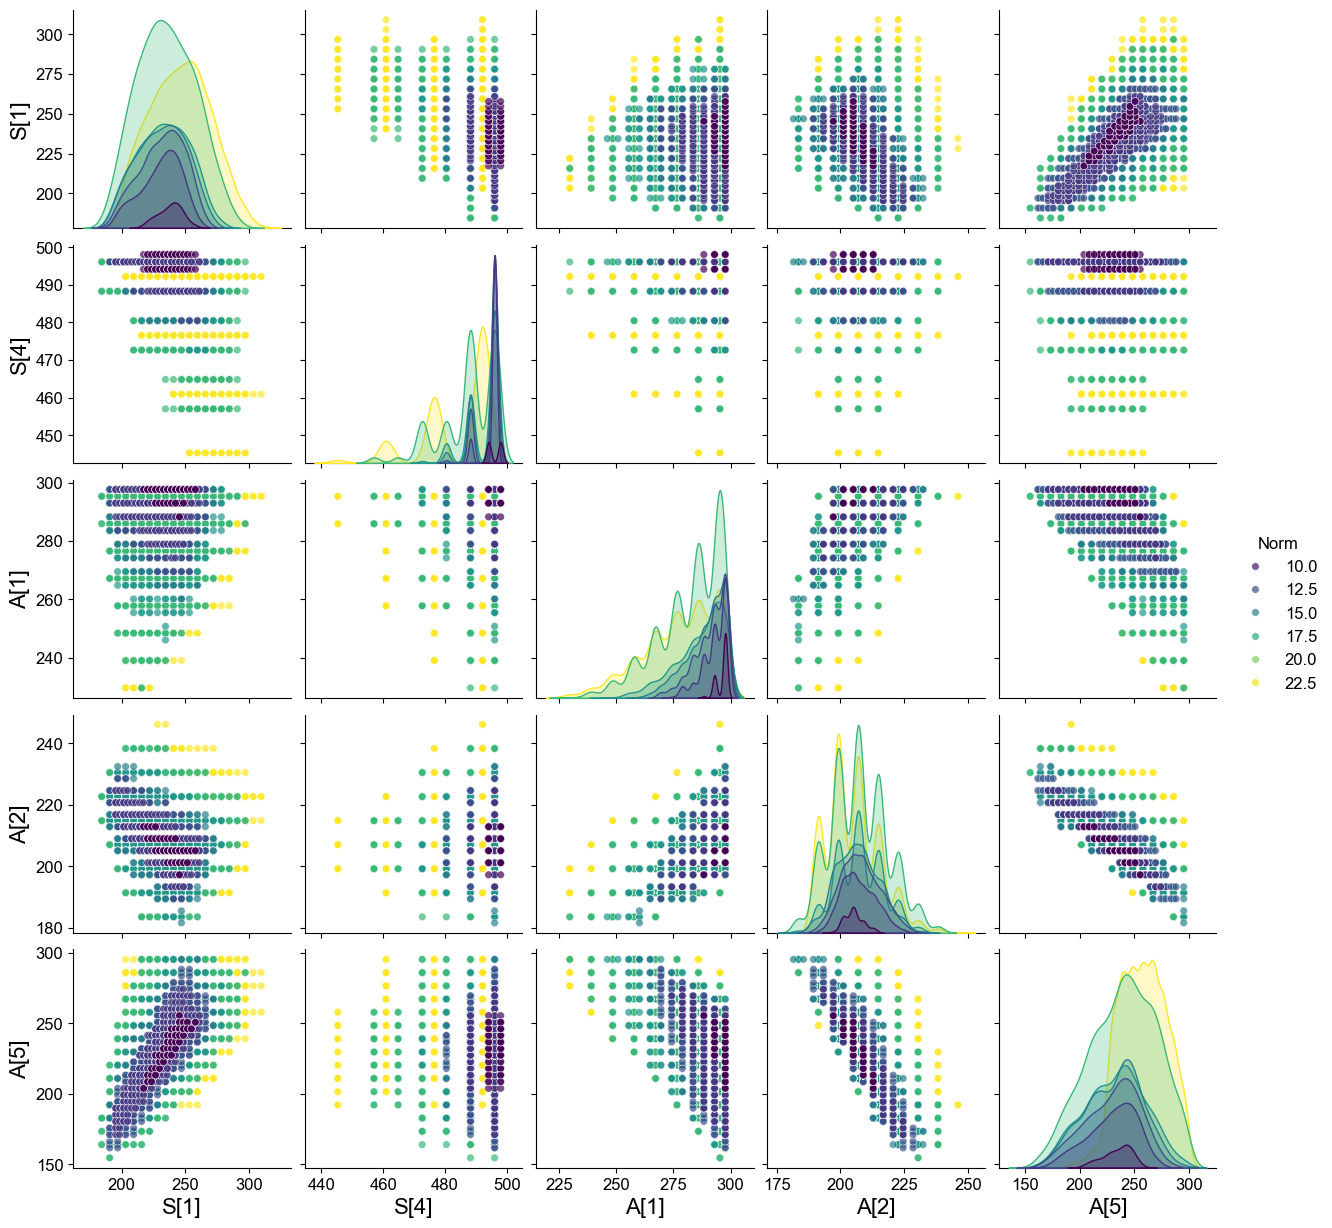

In [ ]:
pairwise_visualize(data,start_from=15000,ignore_columns=["A[3]","A[4]","S[2]","S[3]"])

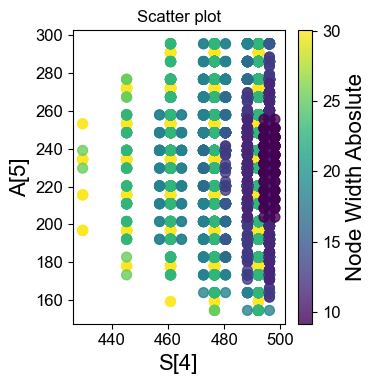

In [ ]:
pairwise_visualize(data,start_from=10000,idx_list=["S[4]","A[5]"],ignore_columns=["A[3]","A[4]","S[2]","S[3]"])

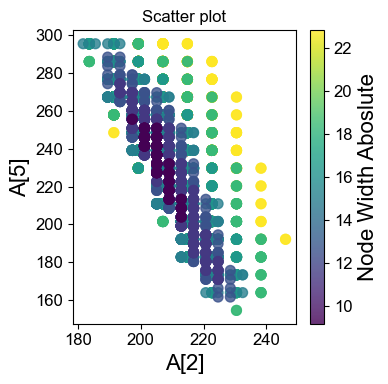

In [ ]:
pairwise_visualize(data,start_from=15000,idx_list=["A[2]","A[5]"],ignore_columns=["A[3]","A[4]","S[2]","S[3]"])

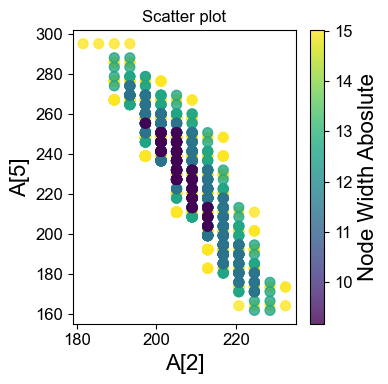

In [ ]:
pairwise_visualize(data,start_from=20000,idx_list=["A[2]","A[5]"],ignore_columns=["A[3]","A[4]","S[2]","S[3]"])

In [5]:
return_cost_per_node(data)

num_nodes_total    time_total  num_nodes_rootless  time_rootless  \
direct               13      6.130000                  12       5.790000   
cz               131042  59457.549988               64163   16772.803696   

        per_node_total  per_node_rootless  
direct        0.471538           0.482500  
cz            0.453729           0.261409

## crude_selection visualize BB (MINLP) k=110.32670095802615

In [8]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/data/crude_selection.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

BB node list (3075/13055)

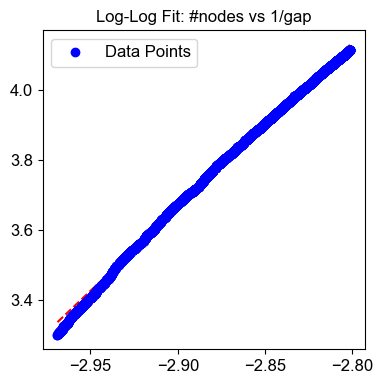

Slope: 4.7353, Intercept: 17.3961, R^2: 0.9977


In [10]:
from scipy.stats import linregress

gap_rec = [1 / g for g in data.res.abs_gaps]
start=1000

x = np.log10(gap_rec[start:])
y = np.log10(data.res.bb_n[start:])
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.plot(x, (intercept + slope * x), 'r--')
plt.plot(x, y, 'bo', label='Data Points')
plt.legend()
plt.title('Log-Log Fit: #nodes vs 1/gap')
plt.show()
print(f"Slope: {slope:.4f}, Intercept: {intercept:.4f}, R^2: {r_value**2:.4f}")

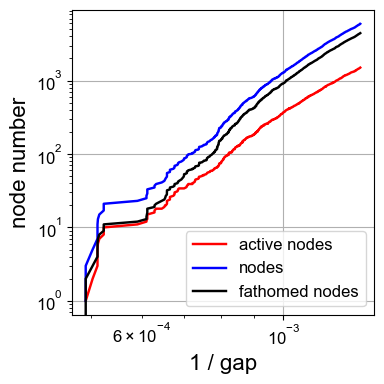

In [ ]:
data.res.plot_bb_n_gap(plot_method='loglog')

In [ ]:
with open("/Users/jyang872/Desktop/data/crude_selection.pkl", "rb") as f:
    data = dill.load(f)
data.node_list

BB node list (2904/12271)

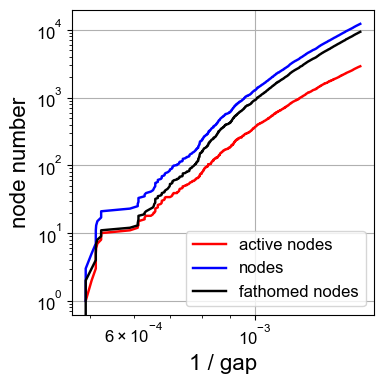

In [ ]:
data.res.plot_bb_n_gap(plot_method='loglog')

In [ ]:

crude_obj = -18350.146929611754
crude_sol = {f'crudeQuantity[{i}]': 0. for i in range(1, 10 + 1)}
crude_sol['crudeQuantity[2]'] = 150.87595641747944
crude_sol['crudeQuantity[3]'] = 201.29570746971186
crude_sol['crudeQuantity[4]'] = 56.18456149457359
crude_sol['crudeQuantity[8]'] = 162.2466500589715
crude_sol['crudeQuantity[10]'] = 18.848116800048512
crude_y_bound = {
    'crudeQuantity[1]': [0, 201.29570747217807],
    'crudeQuantity[2]': [0, 212.48012718600953],
    'crudeQuantity[3]': [0, 201.29570747217807],
    'crudeQuantity[4]': [0, 199.57869634340224],
    'crudeQuantity[5]': [0, 210.54848966613673],
    'crudeQuantity[6]': [0, 222.1383147853736],
    'crudeQuantity[7]': [0, 196.7885532591415],
    'crudeQuantity[8]': [0, 208.54531001589828],
    'crudeQuantity[9]': [0, 204.3720190779014],
    'crudeQuantity[10]': [0, 210.2623211446741]
}
lambda_list = np.linspace(0, 1, 100)

plt.plot(lambda_list, [return_counter(i, data.node_list, crude_sol, crude_y_bound)/data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list, label='y=x')
plt.grid()
plt.xlabel("%search space")
plt.ylabel('%nodes')
plt.title('Crude Selection #nodes vs search space')
plt.show()

In [ ]:
for i in range(12990,13000):
    print(data.node_list.nodes[int(i)].bound["crudeQuantity[4]"])

[59.24992547694754, 62.368342607313195]
[56.13150834658188, 62.368342607313195]
[56.13150834658188, 62.368342607313195]
[74.84201112877584, 81.07884538950717]
[81.07884538950717, 87.31567965023848]
[74.84201112877584, 81.07884538950717]
[74.84201112877584, 81.07884538950717]
[74.84201112877584, 81.07884538950717]
[74.84201112877584, 81.07884538950717]
[68.60517686804451, 71.72359399841017]


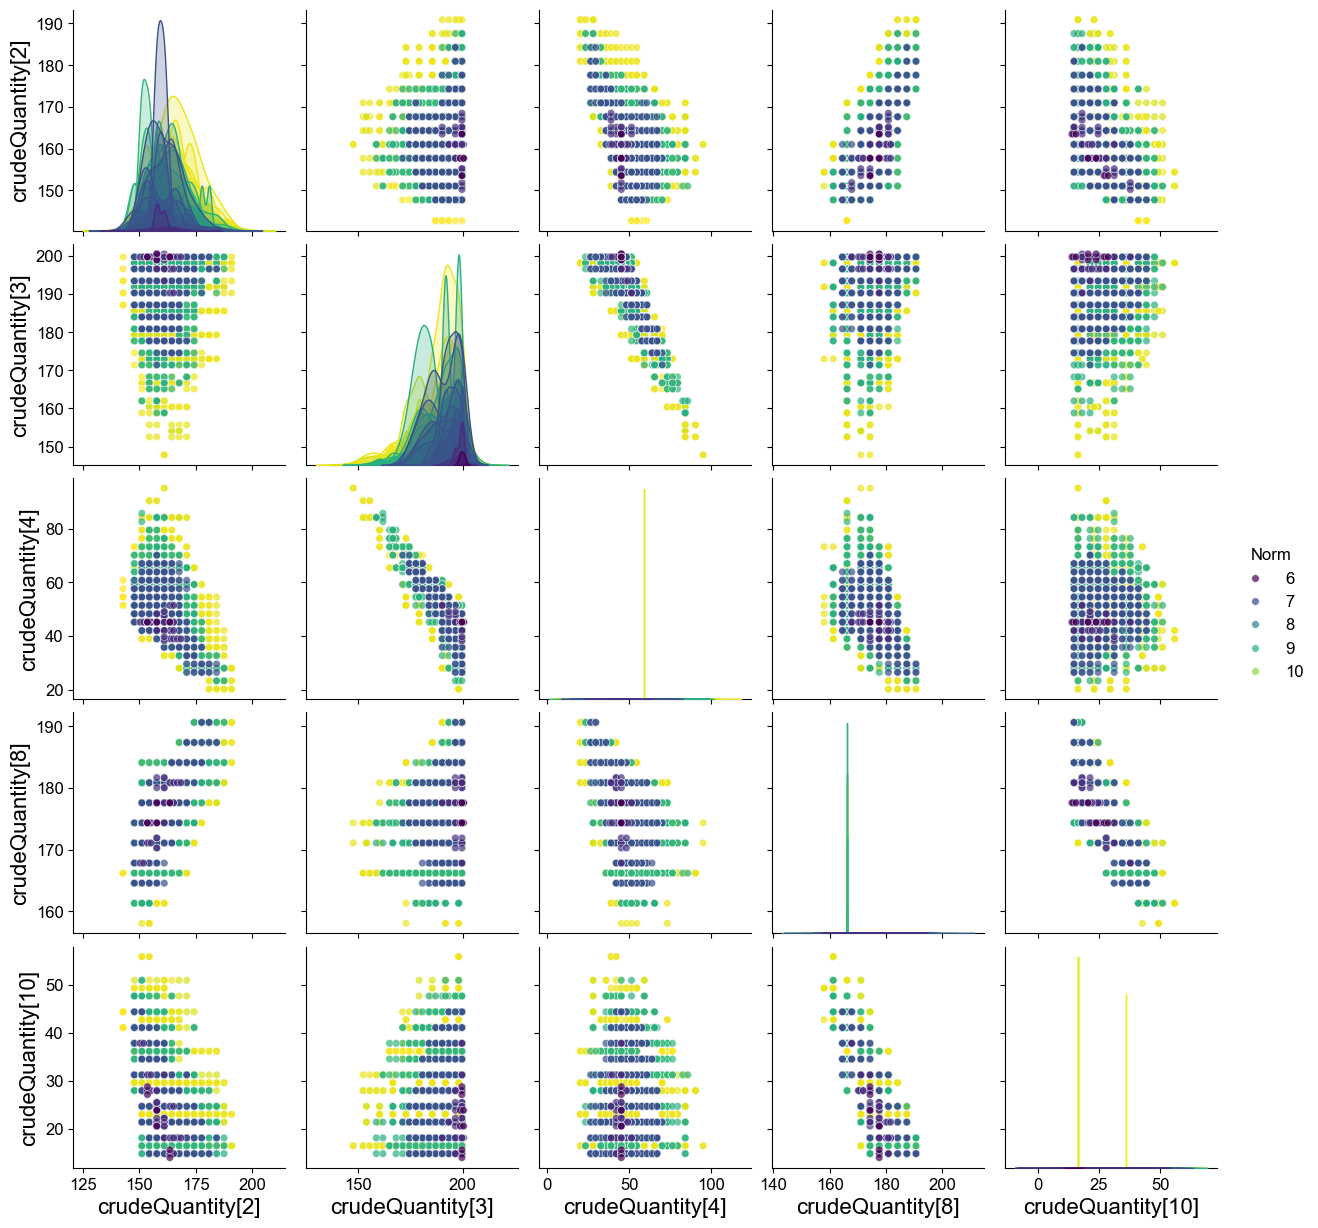

In [ ]:
pairwise_visualize(data,start_from=10000,ignore_columns=["crudeQuantity[1]","crudeQuantity[5]","crudeQuantity[6]","crudeQuantity[7]","crudeQuantity[9]"])

In [ ]:
return_cost_per_node(data)

num_nodes_total     time_total  num_nodes_rootless  time_rootless  \
direct                9       7.160000                   8       4.320000   
cz               590923  144432.607148              536133  108750.307148   

        per_node_total  per_node_rootless  
direct        0.795556           0.540000  
cz            0.244419           0.202842

## Tanksize visualize BB(MINLP) k=0.00023716963121114376

In [ ]:
with open('/Users/jyang872/Documents/decomposition/DecompConv/data/tanksize.pkl', 'rb') as f:
    data = dill.load(f)
data.node_list

BB node list (1/51)

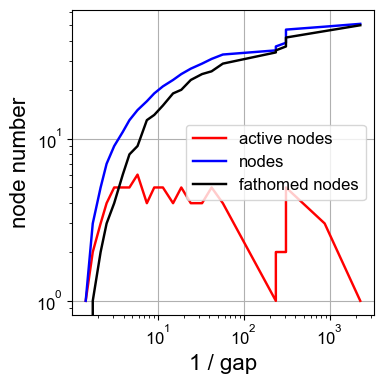

In [ ]:
data.res.plot_bb_n_gap(plot_method='loglog')

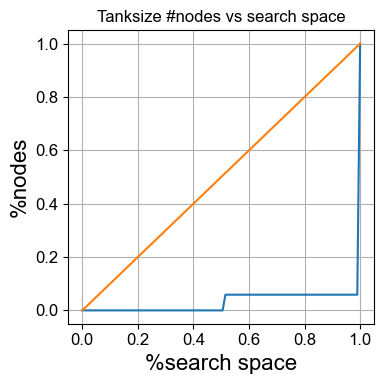

In [ ]:
tanksize_obj=0.9529054839994406
tanksize_sol = { 'productTankSize[1]': 675.9864410532731,
                        'productTankSize[2]': 541.8555067193988,
                        'productTankSize[3]': 257.58675194535505}
tankszie_y_bound = {'productTankSize[1]': [643, 4018.36],
                    'productTankSize[2]': [536, 3348],
                    'productTankSize[3]': [214, 1339.45]}
lambda_list = np.linspace(0, 1, 100)

plt.plot(lambda_list,[return_counter(i,data.node_list,tanksize_sol,tankszie_y_bound)/data.node_list.count_nodes() for i in lambda_list])
plt.plot(lambda_list, lambda_list)
plt.grid()
plt.xlabel('%search space')
plt.ylabel('%nodes')
plt.title('Tanksize #nodes vs search space')
plt.show()

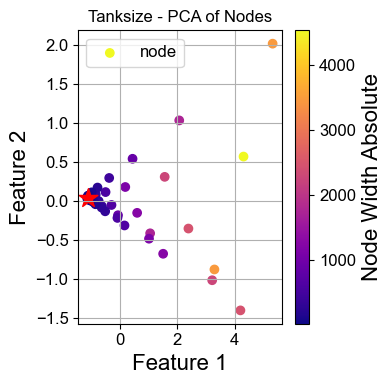

Explained variance ratio: [0.87387506 0.0722941 ]
PCA components: [[ 0.57077628  0.58160661  0.57961037]
 [ 0.81765944 -0.33799128 -0.46604178]]


In [ ]:
pca_nodes(data,instance_name="Tanksize")


In [ ]:
return_cost_per_node(data)

num_nodes_total  time_total  num_nodes_rootless  time_rootless  \
direct                9    0.590000                   8       0.470000   
cz                 1428   97.265541                1279      79.215541   

        per_node_total  per_node_rootless  
direct        0.065556           0.058750  
cz            0.068113           0.061936